# Final Project Report
## Noam Siegel
### Physiological Signal Processing, Ben Gurion University
 #### 367-2-6351



In [1]:
%load_ext autoreload
%autoreload 2

from msc.config import get_config
from msc.dataset import RawDataset

## Load configurations

In [2]:
config = get_config()
for each_section in config.sections():
    for (each_key, each_val) in config.items(each_section):
        print(f"{each_key.upper():26} ===  {each_val}")

RAW_PATH                   ===  C:\raw_data\epilepsiae\surf30\pat_103002\adm_1030102\rec_103001102\103001102_0113.data
DATASETS_PATH_LOCAL        ===  D:\raw_data
DATASET                    ===  epilepsiae
RAW_DATASET_DIR            ===  \\132.72.65.115\epilepsy_data\Epilepsiea\raw_data
PICKS                      ===  one_channel
RESAMPLE                   ===  256
DATASET_PATH_LOCAL         ===  C:\Users\noam\Repositories\noamsgl\msc\results\epilepsiae\max_cross_corr\surfCO\pat_3500\20211213T182128
PREICTAL_MIN_DIFF_HOURS    ===  1
INTERICTAL_MIN_DIFF_HOURS  ===  4
PREICTAL_LABEL             ===  0
INTERICTAL_LABEL           ===  1
RESULTS_DIR_REMOTE         ===  /cs_storage/noamsi/results
RESULTS_DIR_LOCAL          ===  C:\Users\noam\Repositories\noamsgl\msc\results


## Get Raw dataset

In [3]:
raw_dataset = RawDataset(f"{config.get('DATA', 'RAW_DATASET_DIR')}")
raw_dataset.data_df

,package,patient,admission,recording,fname,meas_date,end_date,time_zone,sfreq,nsamples,time_hours,nchan,ch_names,highpass,lowpass,fpath,seizure_table,num_seizures
0,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_018.data,2009-05-20 08:27:43,2009-05-20 08:34:56,UTC,400.0,173550,0.120521,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
1,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_012.data,2009-05-20 02:53:25,2009-05-20 03:49:08,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
2,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_010.data,2009-05-20 01:01:59,2009-05-20 01:57:42,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
3,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_004.data,2009-05-19 19:27:41,2009-05-19 20:23:24,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
4,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_003.data,2009-05-19 18:31:58,2009-05-19 19:27:41,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17519,CO,pat_7800,adm_780100,rec_78010100,78010100_0057.data,2011-09-16 09:38:24,2011-09-16 11:38:24,UTC,1024.0,7372896,2.000026,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17520,CO,pat_7800,adm_780100,rec_78010100,78010100_0037.data,2011-09-15 05:55:27,2011-09-15 07:24:03,UTC,1024.0,5443712,1.476701,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,1
17521,CO,pat_7800,adm_780100,rec_78010100,78010100_0061.data,2011-09-16 16:18:40,2011-09-16 17:33:55,UTC,1024.0,4623808,1.254288,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17522,CO,pat_7800,adm_780100,rec_78010100,78010100_0042.data,2011-09-15 14:45:14,2011-09-15 15:20:22,UTC,1024.0,2159584,0.585825,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0


## Select random data file

In [4]:
data_row = raw_dataset.data_df.query("package == 'surfCO' and patient == 'pat_3500'").sample(1)
data_row.transpose()

,10639
package,surfCO
patient,pat_3500
admission,adm_350100
recording,rec_35010100
fname,35010100_0031.data
meas_date,2009-11-18 14:38:04
end_date,2009-11-18 16:38:04
time_zone,UTC
sfreq,1024.0
nsamples,7372864


## Plot raw data

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2009-11-18 14:38:04 UTC
 nchan: 32
 projs: []
 sfreq: 1024.0 Hz
>


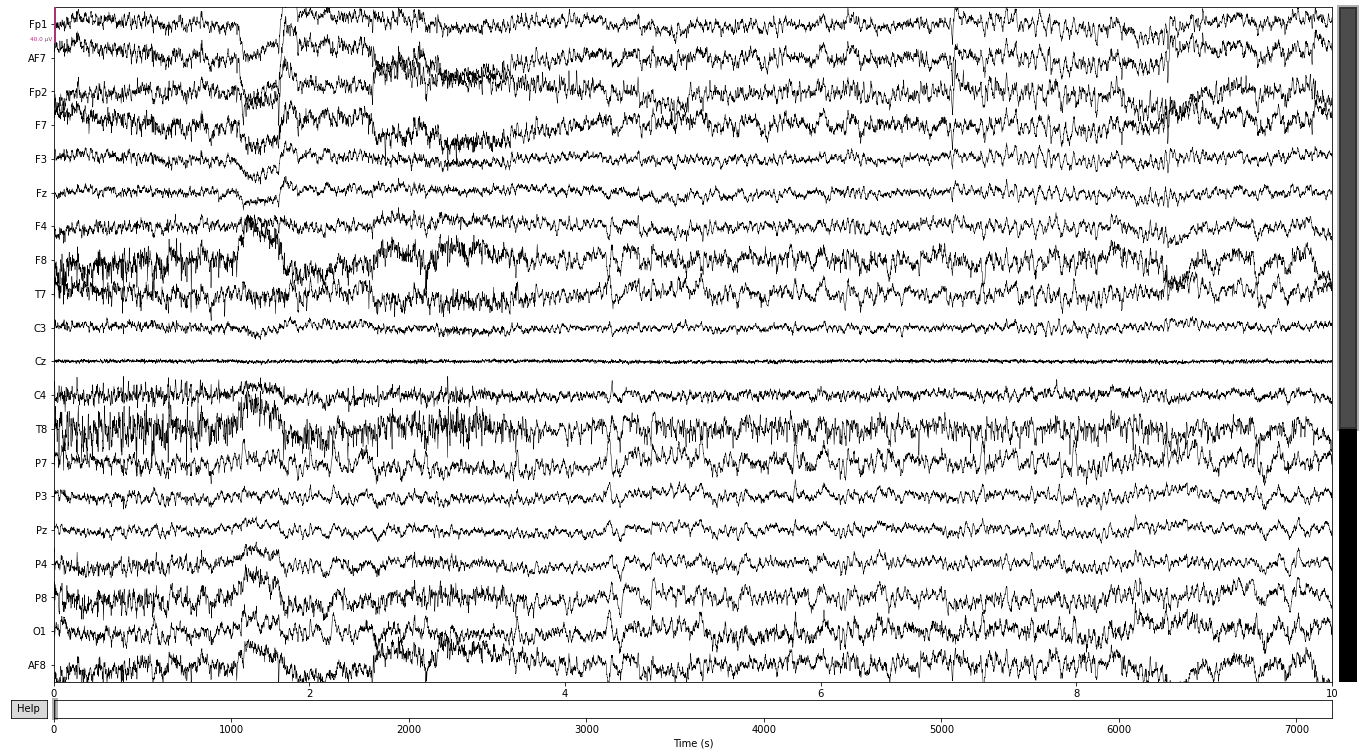

In [12]:
raw = raw_dataset.get_raw(data_row)
print(raw.info)
raw.plot();

## Feature Extraction

## Train Classifier

## Plot Classifier Results

## Variable Selection